# Расчет доли леса на спутниковом изображении

## Подготовка модели и пайплайна

Импорт библиотек

In [1]:
import sys
sys.path.append('..')

import numpy as np
import tensorflow as tf

from tqdm import tqdm

from srr.batchflow import FilesIndex, Dataset, Pipeline, V, B
from srr.batchflow.models.tf import UNet

from srr import AerialBatch
from srr.core.utils import ce_dice_loss, make_mask, gather_image, plot_img_pred_mask

%env CUDA_VISIBLE_DEVICES=6

env: CUDA_VISIBLE_DEVICES=6


Загрузка датасета

In [2]:
ind = FilesIndex(path='../ignore/GPN_AERO_FOREST/*.tif')
ads = Dataset(ind, AerialBatch)
ads.split(0.8, shuffle=42)

In [3]:
classes = (1,)

Настройка параметров пайплайна и загрузка обученной модели

In [4]:
crop_shape = (256, 256)

In [5]:
MODEL_PATH = '../ignore/models/forestation_aerial_32_64_128_cnacna_300ep/'

load_model_config = {
    'build': False,
    'load': {'path': MODEL_PATH}
}

# Прогноз на тестовой части датасета

Определение пайплайна

In [6]:
forestation_ppl = (Pipeline()
      .load(fmt='image', dst='images')
      .load(fmt='mask', dst='masks')
      .scale(factor=0.2, src=['images', 'masks'], dst=['images', 'masks'])
      .make_crops(size=crop_shape, src=['images', 'masks'], dst=['images', 'masks'])
      .unstack_crops()
      .to_array(src=['images', 'masks'], dst=['images', 'masks'])
      .apply_transform(make_mask, classes=classes, src='masks', dst='masks')
      .init_variable('predictions', init_on_each_run=list)
      .init_variable('images', init_on_each_run=list)
      .init_variable('masks', init_on_each_run=list)
      .init_model('static', UNet, 'unet', config=load_model_config)
      .predict_model('unet', images=B('images'), fetches=['proba'], save_to=[B('predictions', mode='w')])
      .update_variable('images', B('images'), mode='e')
      .update_variable('masks', B('masks'), mode='e')
      .update_variable('predictions', B('predictions'), mode='e')
).run(1, n_epochs=1, lazy=True)

INFO:tensorflow:Restoring parameters from ../ignore/models/forestation_aerial_32_64_128_cnacna_300ep/model-1200


In [7]:
ppl = forestation_ppl << ads.test

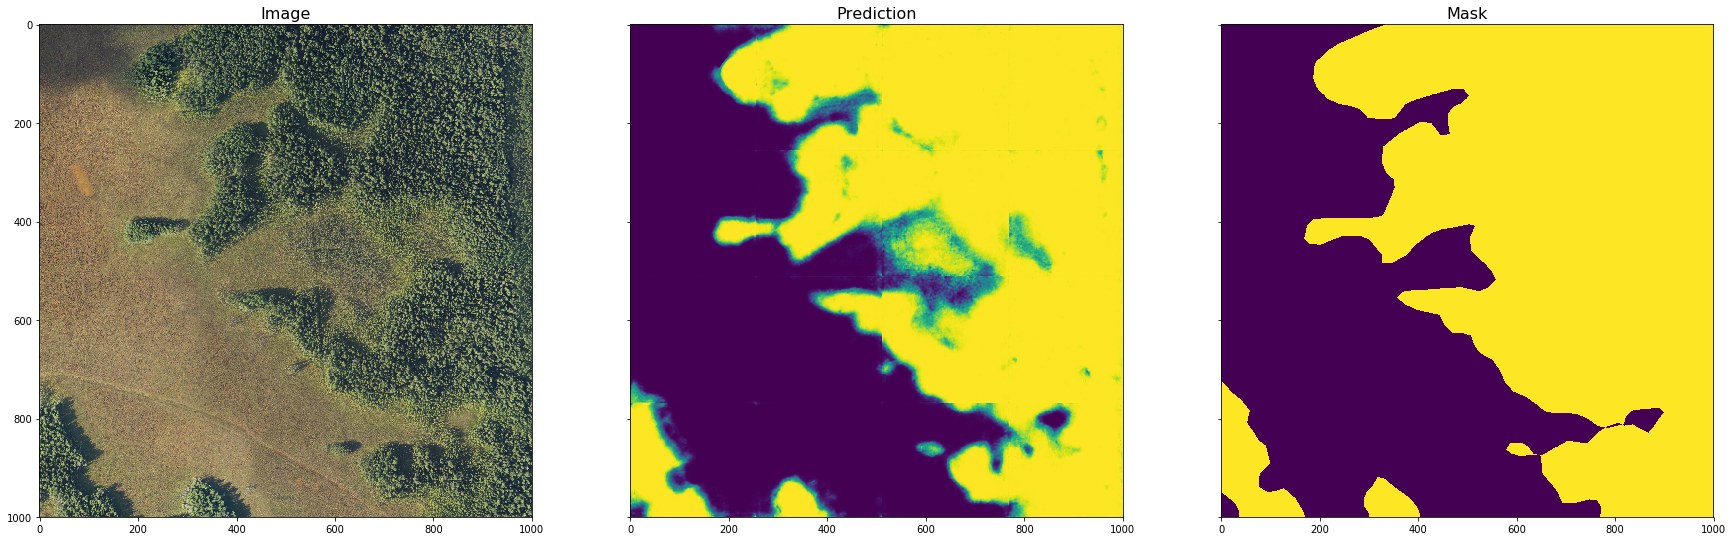

Percentage of forest cover: predicted - 55.44%, ground truth - 56.71%


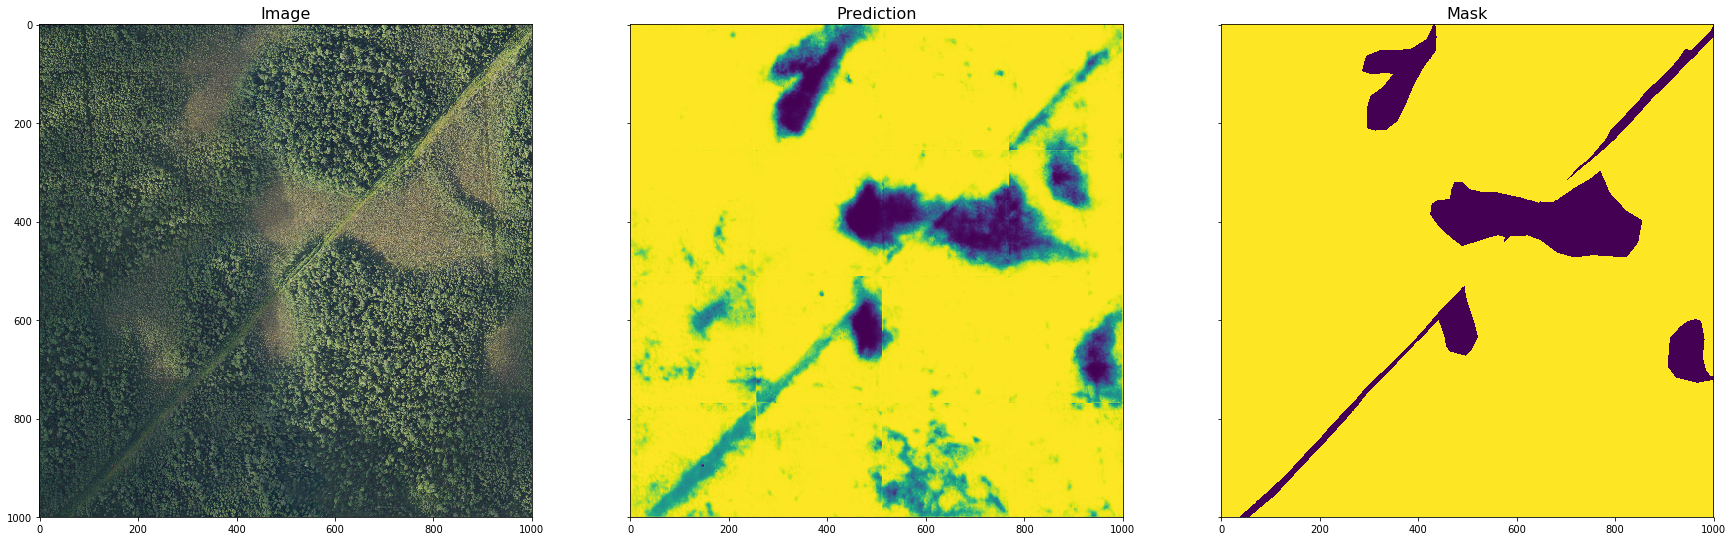

Percentage of forest cover: predicted - 91.33%, ground truth - 91.41%


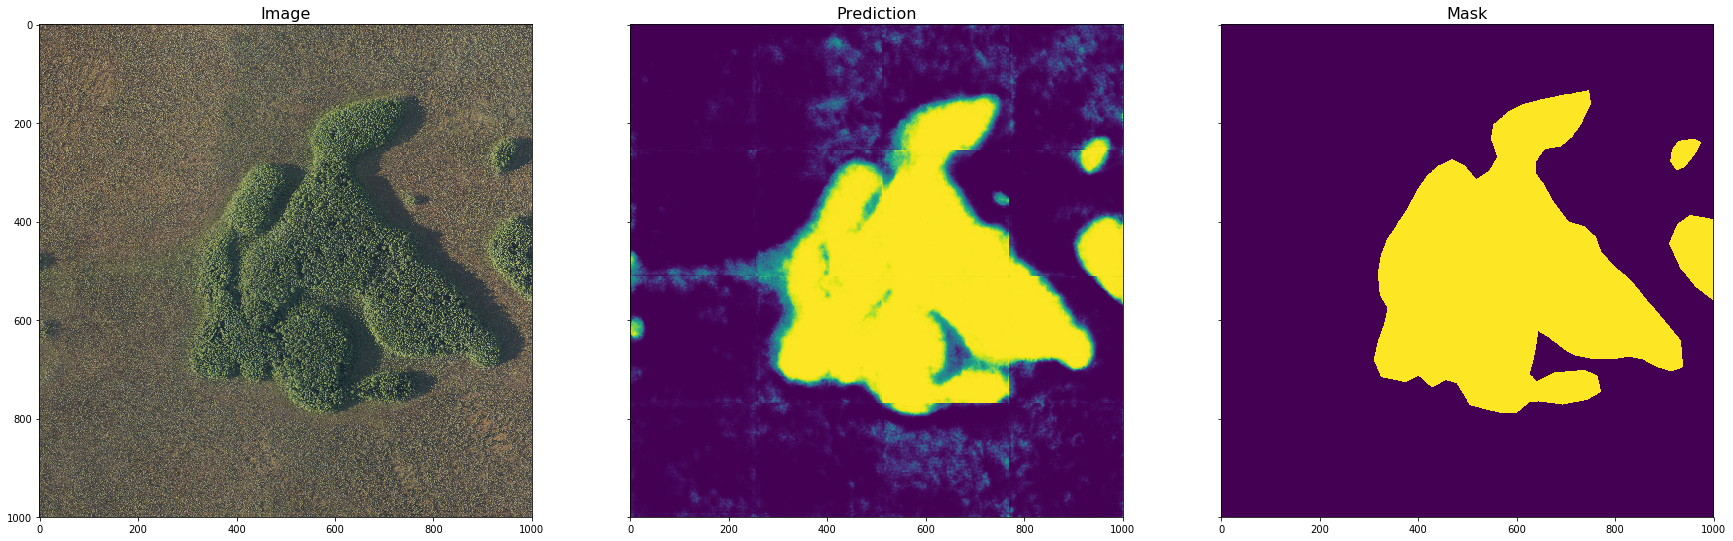

Percentage of forest cover: predicted - 24.92%, ground truth - 23.55%


Средняя ошибка оценки залесённости по 3 снимкам: 0.91%


In [10]:
# Число снимков для прогноза и отрисовки, от 0 до 16
N = 3

errors = []
for _ in ads.test.indices[:N]:
    b = ppl.next_batch(batch_size=1)

    y_pred = ppl.get_variable('predictions')
    img, mask, pred = gather_image(b, original_size=(1000, 1000), crop_shape=crop_shape)
    
    pred = pred[:1000, :1000, 1]
    img = img[:1000, :1000, :]
    mask = mask[:1000, :1000, 1]

    plot_img_pred_mask(img, pred, mask, True)
    
    errors.append((np.sum(pred > 0.5) / pred.size) * 100 - np.sum(mask) / mask.size * 100)
    
print('\n\nСредняя ошибка оценки залесённости по {} снимкам: {:.2f}%'.format(N, np.mean(np.abs(errors))))

Средняя ошибка оценки залесённости на 16 снимках: 2.34%